<img src="imgs/qiskit.png" alt="QisKit" style="width: 50px;" align="right"/>

# Shor's Algorithm

<hr>

## Teach Me Qiskit

In [1]:
from math import gcd, sqrt # used in RSA
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
from qiskit import *

### Prime Numbers

<hr>

<img src="imgs/primes.png" alt="Prime Visual - Wikimedia Commons" style="width: 235px;"/>

<br>

|  Composite numbers  |  Prime numbers  |
|:---:|:---:|
|  1  |     |
|     |  2  |
|     |  3  |
|  4  |     |
|     |  5  |
|  6  |     |
|     |  7  |
|  8  |     |
|  9  |     |

In [2]:
# https://stackoverflow.com/questions/11619942/print-series-of-prime-numbers-in-python

# all of the prime numbers between 2 and 10 (1 is not considered "prime")
for num in range(2, 10):
    if all(num % i != 0 for i in range(2, num)):
        print(num)

2
3
5
7


### What is RSA Encryption?

####     Asymmetric Algorithm:
        - generates a public and private key 
        - used in the encryption and decryption of data

<hr>

<img src="imgs/rsa.png" alt="RSA Encryption" style="width: 500px;"/>

        - utilizes the fact that it is extremely hard to find the prime factors of a large composite (semiprime) number

<center>$a \times b = 6$</center>
        
        - labeled the "prime factorization problem"


The multiplication of these two numbers is _considerably_ more simple

In [3]:
a = 2
b = 3

print(f"{a} x {b} = {a * b}") # Demonstration of simple multiplication

2 x 3 = 6


#### Finding Primes

Sieve of Eratosthenes
<img src="imgs/sieve.png" alt="Sieve of Eratosthenes" style="width: 400px;"/>

In [4]:
# https://www.geeksforgeeks.org/find-two-distinct-prime-numbers-with-given-product/

def Sieve_of_Eratosthenes(n, isPrime):
    isPrime[0], isPrime[1] = False, False
    for i in range(2, n + 1):
        isPrime[i] = True
    for p in range(2, int(sqrt(n)) + 1):
        if isPrime[p] == True:
            for i in range(p * 2, n + 1, p):
                isPrime[i] = False

def find_primes(n):
    isPrime = [False] * (n + 1)
    Sieve_of_Eratosthenes(n, isPrime)
    for i in range(2, n):
        x = int(n / i)
        if isPrime[i] & isPrime[x] and x != i and x * i == n:
            return i, x

In [5]:
c, d = find_primes(6)
print(f"{c} x {d} = {a * b}") # Demonstrate the difficulty in finding prime factors

2 x 3 = 6


#### RSA Algorithm Implimentation

We can use two distinct primes to create a public and private key used to encrypt and decrypt respectively.

Let's use P and Q as our two distinct prime numbers

In [6]:
P = 2
Q = 13

#### What are public/ private keys?

Key Visual
<img src="imgs/keys.png" alt="Public/ Private Key Visual" style="width: 300px;"/>

Create a function to generate public and private RSA keys

In [7]:
def rsa(P, Q):
    N = P * Q # modulus <-- the hard number to crack!
    
    if N > 99:
        raise OverflowError(f"{P} and {Q} are too large for Shor's Algorithm to run on hardware as their product is {P * Q}.")
        
    
    L = (Q - 1) * (P - 1) # number of non-common factors (1, N)

    for E in range(2, L): # between (2, L)
        if gcd(L, E) * gcd(N, E) == 1: # coprime with both L and N
            break # E is public value

    D = 1
    while True:
        if D * E % L == 1 and D != E and D != N:
            break # D is private value
        D += 1

    return ((E, N), (D, N))

In [8]:
pub_key, priv_key = rsa(P, Q)
print("Public key:", pub_key) # Public key used for encryption
print("Private key:", priv_key)

Public key: (5, 26)
Private key: (17, 26)


We can now encrypt a super secret string

In [9]:
string = "qiskit"
string = string.upper()
print("Super secret string:", string)

inter = [ord(char)-ord('A') for char in string]

Super secret string: QISKIT


In [10]:
def enc(code, key):
    E, N = key
    return (code**E) % N

def dec(code, key):
    D, N = key
    return (code**D) % N

In [11]:
encoded = [enc(val, pub_key) for val in inter]
enc_str = "".join([chr(i+ord('A')) for i in encoded]) # Encrypted string
print("Encoded string:", enc_str)

Encoded string: WISEIP


In [12]:
decoded = [chr(dec(val, priv_key)+ord('A')) for val in encoded]
print("Decoded string:", ''.join(decoded))

Decoded string: QISKIT


*Keep in mind, this is a very simple and ineffective implementation of RSA encryption. The goal of this tutorial is to demonstrate Peter Shor's factoring algorithm applied to a situation not best RSA encryption practices.*

### Shor's Algorithm

<hr>

<img src="imgs/shors.png" alt="Prime Visual - Wikimedia Commons" style="width: 400px;"/>

Shor's Algorithm quickly determines two distinct prime numbers which multiply to produce a given number.

Let's assume we don't have access to the private key

Instead, all we have is the __encoded text__ and __public key__. Your mission, should you choose to accept it, is to find what the decoded text is with Shor's algorithm.

In [13]:
E, N = pub_key

print("You are assigned a mission on the following notecard:\n\n",
        f" {(18 + len(enc_str))*'_'}\n",
        "|", (16 + len(enc_str))*' ', "|\n",
        "| Decrypt this secret:", (len(enc_str) - 5)*' ', "|\n",
        "|", (16 + len(enc_str))*' ', "|\n",
        f"| Encoded string: {enc_str} |\n",
        f"| Public key: {pub_key}", ((18 + len(enc_str)) - (16 + len(str(pub_key))))*' ', " |\n",
        "|", (16 + len(enc_str))*' ', "|\n",
        f"|{(18 + len(enc_str))*'_'}|")

You are assigned a mission on the following notecard:

  ________________________
 |                        |
 | Decrypt this secret:   |
 |                        |
 | Encoded string: WISEIP |
 | Public key: (5, 26)    |
 |                        |
 |________________________|


In [14]:
def dec_guess(string, key):
    D, N = key
    return "".join([chr((((ord(char) - ord('A'))**D) % N) + ord('A')) for char in string])

Here we can observe that random guesses would be infeasible for larger primes

In [15]:
for i in range(5):
    print(dec_guess(enc_str, (i, N)))

BBBBBB
WISEIP
QMMQMR
OSIMSV
WOOWOD


In [16]:
qr = QuantumRegister(14)
cr = ClassicalRegister(14)

circuit = QuantumCircuit(qr, cr)

circuit.x(qr[13])
circuit.h(qr)
circuit.measure(qr, cr)

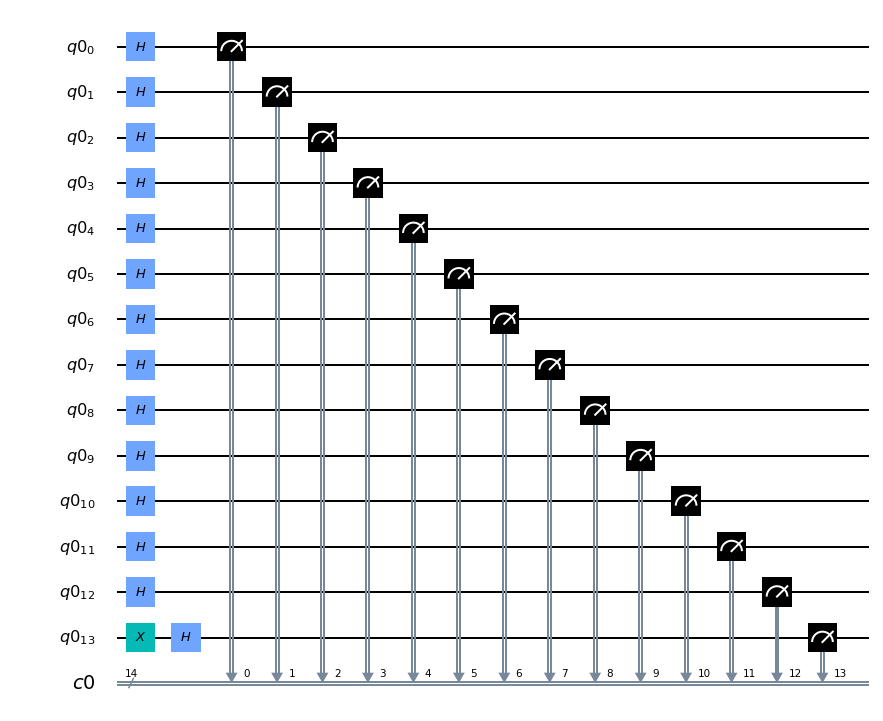

In [17]:
circuit.draw(output="mpl")

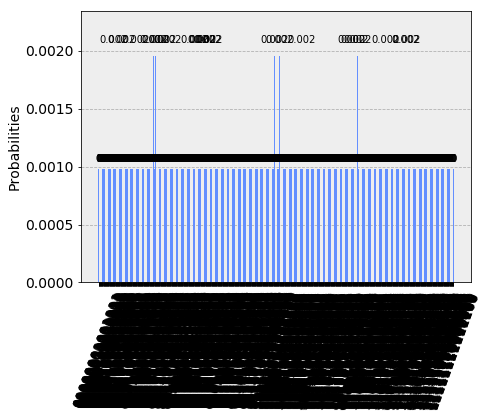

In [18]:
simulator = Aer.get_backend("qasm_simulator")
execute(circuit, backend=simulator)

result = execute(circuit, backend=simulator).result()

visualization.plot_histogram(result.get_counts(circuit))

In [19]:
# IBMQ.save_account("ff7b7f43d8ed961867f6638374abf00274866beb9c65ff22dc8d77c57d82f6fa02dbc0280f9a9afaaaee5041ee56bb2c6ce0ffbe966a70a1f08f4cdb24f3bb1d", overwrite=True)
# IBMQ.load_account()

# provider = IBMQ.get_provider("ibm-q")
# qcomp = provider.get_backend("ibmq_16_melbourne")

# job = execute(circuit, backend=qcomp)
# from  import job_monitor
# job_monitor(job)

# result = job.result()
# plot_histogram(result.get_count(circuit))